# Failure Pattern Analysis

This notebook analyzes failure patterns in the project implementation system to identify:
- Most common error types
- Languages with highest failure rates
- Retry attempt distributions
- Temporal patterns in failures
- Error clustering and categorization

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from collections import Counter, defaultdict
import re

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data Sources

In [2]:
# Load error log
error_log_path = Path('implementation_outputs/error_log.json')
retry_queue_path = Path('implementation_outputs/retry_queue.json')
implementations_path = Path('implementation_outputs')

error_log = []
if error_log_path.exists():
    with open(error_log_path) as f:
        error_log = json.load(f)
else:
    print(f"⚠️  Error log not found at: {error_log_path.absolute()}")

retry_queue = []
if retry_queue_path.exists():
    with open(retry_queue_path) as f:
        retry_queue = json.load(f)
else:
    print(f"⚠️  Retry queue not found at: {retry_queue_path.absolute()}")

print(f"📊 Loaded {len(error_log)} error records")
print(f"🔄 Current retry queue: {len(retry_queue)} projects")
print(f"📁 Implementation outputs: {implementations_path.absolute()}")

📊 Loaded 276 error records
🔄 Current retry queue: 1 projects
📁 Implementation outputs: /home/pi/Desktop/test/create/implementation_outputs


## Error Classification

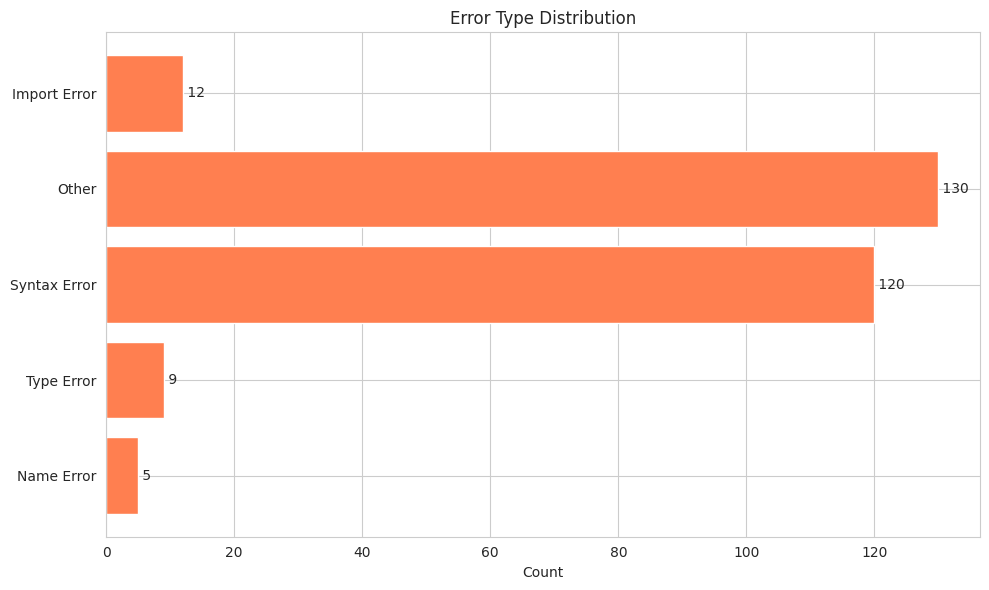


📊 Error Category Summary:
  Other               :  130 (47.1%)
  Syntax Error        :  120 (43.5%)
  Import Error        :   12 (4.3%)
  Type Error          :    9 (3.3%)
  Name Error          :    5 (1.8%)


In [3]:
def classify_error(error_msg):
    """Classify error into categories"""
    error_lower = error_msg.lower()
    
    if 'syntax' in error_lower or 'syntaxerror' in error_lower:
        return 'Syntax Error'
    elif 'import' in error_lower or 'modulenotfound' in error_lower:
        return 'Import Error'
    elif 'name' in error_lower and 'not defined' in error_lower:
        return 'Name Error'
    elif 'type' in error_lower and 'error' in error_lower:
        return 'Type Error'
    elif 'index' in error_lower:
        return 'Index Error'
    elif 'key' in error_lower and 'error' in error_lower:
        return 'Key Error'
    elif 'attribute' in error_lower:
        return 'Attribute Error'
    elif 'timeout' in error_lower:
        return 'Timeout'
    elif 'connection' in error_lower or 'network' in error_lower:
        return 'Network Error'
    elif 'permission' in error_lower:
        return 'Permission Error'
    else:
        return 'Other'

# Classify all errors
error_categories = Counter()
for error in error_log:
    if 'error_message' in error:
        category = classify_error(error['error_message'])
        error_categories[category] += 1

# Plot error distribution
if error_categories:
    fig, ax = plt.subplots(figsize=(10, 6))
    categories = list(error_categories.keys())
    counts = list(error_categories.values())
    
    ax.barh(categories, counts, color='coral')
    ax.set_xlabel('Count')
    ax.set_title('Error Type Distribution')
    ax.invert_yaxis()
    
    for i, v in enumerate(counts):
        ax.text(v, i, f' {v}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Error Category Summary:")
    for category, count in error_categories.most_common():
        pct = (count / len(error_log)) * 100
        print(f"  {category:20s}: {count:4d} ({pct:.1f}%)")
else:
    print("No error data available for classification")

## Language-Specific Failure Rates

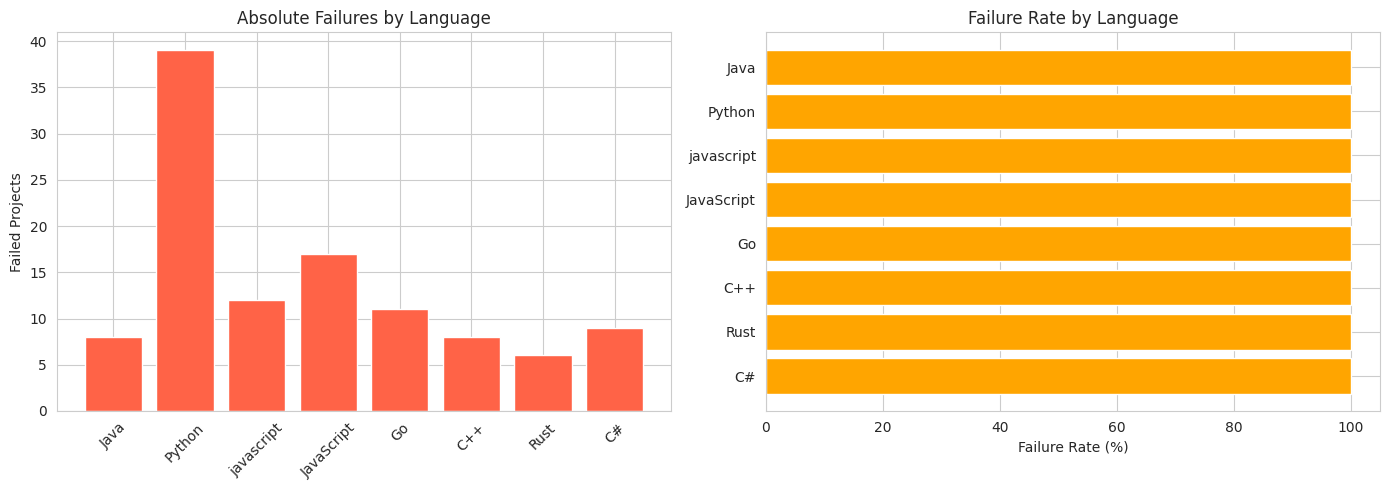


📊 Language Failure Analysis:
  Java           :   8/  8 failed (100.0%)
  Python         :  39/ 39 failed (100.0%)
  javascript     :  12/ 12 failed (100.0%)
  JavaScript     :  17/ 17 failed (100.0%)
  Go             :  11/ 11 failed (100.0%)
  C++            :   8/  8 failed (100.0%)
  Rust           :   6/  6 failed (100.0%)
  C#             :   9/  9 failed (100.0%)


In [4]:
# Analyze failures by language
language_failures = Counter()
language_total = Counter()

# Check all implementations
implementations_dir = Path('implementation_outputs')
if implementations_dir.exists():
    for proj_dir in implementations_dir.iterdir():
        if not proj_dir.is_dir():
            continue
        
        metadata_file = proj_dir / 'project_metadata.json'
        if metadata_file.exists():
            try:
                with open(metadata_file) as f:
                    meta = json.load(f)
                    lang = meta.get('language', 'Unknown')
                    qa_score = meta.get('qa_score', 0)
                    
                    language_total[lang] += 1
                    if qa_score < 98:
                        language_failures[lang] += 1
            except:
                pass

# Calculate failure rates
failure_rates = {}
for lang in language_total:
    if language_total[lang] > 0:
        failure_rates[lang] = (language_failures[lang] / language_total[lang]) * 100

if failure_rates:
    # Plot failure rates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Absolute failures
    languages = list(language_failures.keys())
    failures = [language_failures[l] for l in languages]
    ax1.bar(languages, failures, color='tomato')
    ax1.set_ylabel('Failed Projects')
    ax1.set_title('Absolute Failures by Language')
    ax1.tick_params(axis='x', rotation=45)
    
    # Failure rates
    sorted_langs = sorted(failure_rates.items(), key=lambda x: x[1], reverse=True)
    langs, rates = zip(*sorted_langs) if sorted_langs else ([], [])
    ax2.barh(list(langs), list(rates), color='orange')
    ax2.set_xlabel('Failure Rate (%)')
    ax2.set_title('Failure Rate by Language')
    ax2.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Language Failure Analysis:")
    for lang, rate in sorted(failure_rates.items(), key=lambda x: x[1], reverse=True):
        total = language_total[lang]
        failed = language_failures[lang]
        print(f"  {lang:15s}: {failed:3d}/{total:3d} failed ({rate:.1f}%)")
else:
    print(f"No implementation data available at {implementations_dir.absolute()}")

## Retry Attempt Distribution

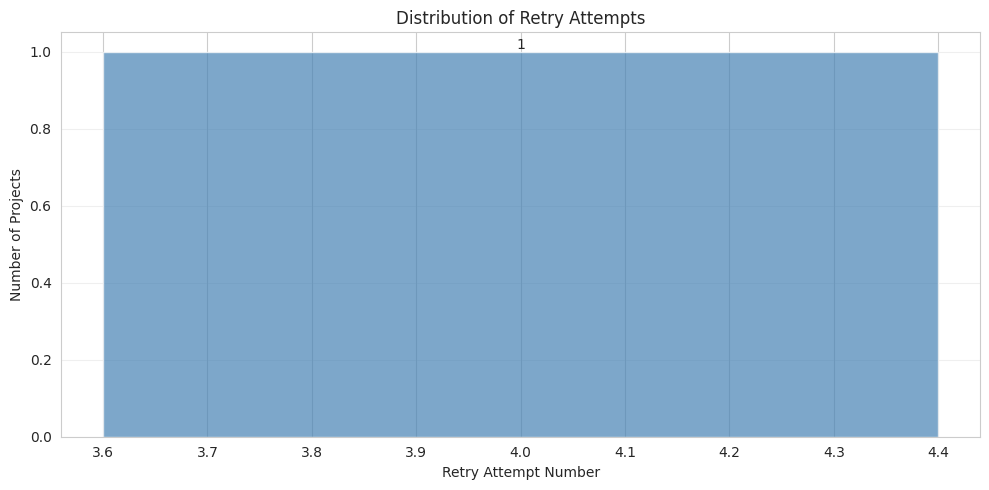


📊 Retry Statistics:
  Total in retry queue: 1
  Average attempts: 4.00
  Max attempts: 4
  Projects on first retry: 0
  Projects on 4+ retries: 1


In [5]:
# Analyze retry attempts
retry_counts = []
for item in retry_queue:
    retry_counts.append(item.get('retry_count', 0))

if retry_counts:
    retry_distribution = Counter(retry_counts)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    attempts = sorted(retry_distribution.keys())
    counts = [retry_distribution[a] for a in attempts]
    
    ax.bar(attempts, counts, color='steelblue', alpha=0.7)
    ax.set_xlabel('Retry Attempt Number')
    ax.set_ylabel('Number of Projects')
    ax.set_title('Distribution of Retry Attempts')
    ax.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(counts):
        ax.text(attempts[i], v, str(v), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Retry Statistics:")
    print(f"  Total in retry queue: {len(retry_counts)}")
    print(f"  Average attempts: {sum(retry_counts)/len(retry_counts):.2f}")
    print(f"  Max attempts: {max(retry_counts)}")
    print(f"  Projects on first retry: {retry_distribution.get(1, 0)}")
    print(f"  Projects on 4+ retries: {sum(v for k, v in retry_distribution.items() if k >= 4)}")
else:
    print("Retry queue is empty - good news!")

## Temporal Analysis

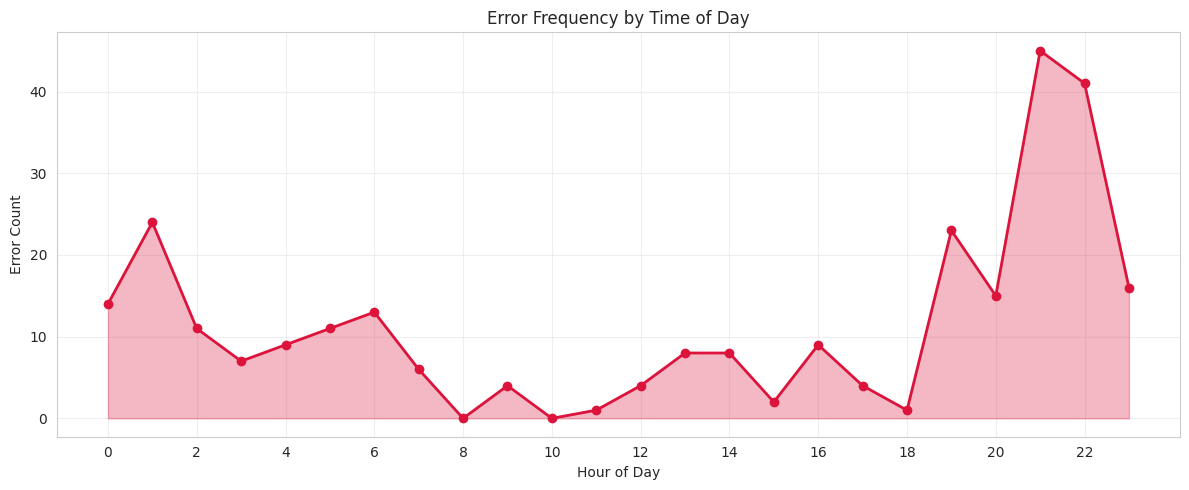


⏰ Peak error hour: 21:00 (45 errors)


In [6]:
# Analyze when errors occur
error_times = []
for error in error_log:
    if 'timestamp' in error:
        try:
            dt = datetime.fromisoformat(error['timestamp'].replace('Z', '+00:00'))
            error_times.append(dt)
        except:
            pass

if error_times:
    # Extract hour of day
    hours = [dt.hour for dt in error_times]
    hour_distribution = Counter(hours)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    all_hours = range(24)
    counts = [hour_distribution.get(h, 0) for h in all_hours]
    
    ax.plot(all_hours, counts, marker='o', linewidth=2, markersize=6, color='crimson')
    ax.fill_between(all_hours, counts, alpha=0.3, color='crimson')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Error Count')
    ax.set_title('Error Frequency by Time of Day')
    ax.set_xticks(range(0, 24, 2))
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find peak error times
    peak_hour = max(hour_distribution.items(), key=lambda x: x[1])[0]
    print(f"\n⏰ Peak error hour: {peak_hour}:00 ({hour_distribution[peak_hour]} errors)")
else:
    print("No timestamp data available for temporal analysis")

## Recommendations

In [7]:
print("\n🎯 RECOMMENDATIONS BASED ON ANALYSIS:\n")

if error_categories:
    top_error = error_categories.most_common(1)[0]
    print(f"1. Focus on {top_error[0]} - accounts for {(top_error[1]/len(error_log)*100):.1f}% of all errors")

if failure_rates:
    worst_lang = max(failure_rates.items(), key=lambda x: x[1])
    print(f"2. Improve {worst_lang[0]} generation - {worst_lang[1]:.1f}% failure rate")

if retry_counts:
    high_retry_count = sum(1 for c in retry_counts if c >= 4)
    if high_retry_count > 0:
        print(f"3. {high_retry_count} projects have 4+ retries - consider escalating_retry_system improvements")

print("\n4. Review mk14.py code generation prompts for most common error types")
print("5. Check escalating_retry_system.py learning database effectiveness")
print("6. Consider adding more specific error handling for top failure categories")


🎯 RECOMMENDATIONS BASED ON ANALYSIS:

1. Focus on Other - accounts for 47.1% of all errors
2. Improve Java generation - 100.0% failure rate
3. 1 projects have 4+ retries - consider escalating_retry_system improvements

4. Review mk14.py code generation prompts for most common error types
5. Check escalating_retry_system.py learning database effectiveness
6. Consider adding more specific error handling for top failure categories
